# OVERVIEW

- We compress MNIST data (784 dimensions) into 2 dimensions and then uncompress back to the original size.
- Similare to PCA, except this will be a non-linear dimensionality reduction, due to the non-linear activation functions.

In [1]:
# IMPORTS
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.layers import Input, Dense, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# MNIST Dataset
(x_train_orig, y_train), (x_test_orig, y_test) = load_data()
x_train_orig = x_train_orig.astype("float32") / 255.0
x_test_orig = x_test_orig.astype("float32") / 255.0

x_train = x_train_orig.reshape(-1, 28 ** 2)
x_test = x_test_orig.reshape(-1, 28 ** 2)

x_train.shape, x_test.shape

((60000, 784), (10000, 784))

In [3]:
# MODEL PARAMETERS
d = 2

In [4]:
# ENCODER
x = Input(shape=(784), name="encoder_input")

encoder_dense_layer1 = Dense(units=300, name="encoder_dense_1")(x)
encoder_activ_layer1 = LeakyReLU(name="encoder_leakyrelu_1")(encoder_dense_layer1)

encoder_dense_layer2 = Dense(units=d, name="encoder_dense_2")(encoder_activ_layer1)
encoder_output = LeakyReLU(name="encoder_output")(encoder_dense_layer2)

encoder = Model(x, encoder_output, name="encoder_model")
encoder.summary()

Model: "encoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 784)]             0         
_________________________________________________________________
encoder_dense_1 (Dense)      (None, 300)               235500    
_________________________________________________________________
encoder_leakyrelu_1 (LeakyRe (None, 300)               0         
_________________________________________________________________
encoder_dense_2 (Dense)      (None, 2)                 602       
_________________________________________________________________
encoder_output (LeakyReLU)   (None, 2)                 0         
Total params: 236,102
Trainable params: 236,102
Non-trainable params: 0
_________________________________________________________________


In [5]:
# DECODER
decoder_input = Input(shape=(d), name="decoder_input")

decoder_dense_layer1 = Dense(units=300, name="decoder_dense_1")(decoder_input)
decoder_activ_layer1 = LeakyReLU(name="decoder_leakyrelu_1")(decoder_dense_layer1)

decoder_dense_layer2 = Dense(units=784, name="decoder_dense_2")(decoder_activ_layer1)
decoder_output = LeakyReLU(name="decoder_output")(decoder_dense_layer2)

decoder = Model(decoder_input, decoder_output, name="decoder_model")
decoder.summary()

Model: "decoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
decoder_dense_1 (Dense)      (None, 300)               900       
_________________________________________________________________
decoder_leakyrelu_1 (LeakyRe (None, 300)               0         
_________________________________________________________________
decoder_dense_2 (Dense)      (None, 784)               235984    
_________________________________________________________________
decoder_output (LeakyReLU)   (None, 784)               0         
Total params: 236,884
Trainable params: 236,884
Non-trainable params: 0
_________________________________________________________________


In [6]:
# AUTO ENCODER
ae_input = Input(shape=(784), name="AE_input")
ae_encoder_output = encoder(ae_input)
ae_decoder_output = decoder(ae_encoder_output)

ae = Model(ae_input, ae_decoder_output, name="AE")
ae.summary()

Model: "AE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
AE_input (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
encoder_model (Model)        (None, 2)                 236102    
_________________________________________________________________
decoder_model (Model)        (None, 784)               236884    
Total params: 472,986
Trainable params: 472,986
Non-trainable params: 0
_________________________________________________________________


In [7]:
# TRAINING
ae.compile(loss="mse", optimizer=Adam(lr=0.0005))
ae.fit(x_train, x_train, epochs=20, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 2s 32us/sample - loss: 0.0609 - val_loss: 0.0551
Epoch 2/20
60000/60000 [==============================] - 2s 33us/sample - loss: 0.0544 - val_loss: 0.0533
Epoch 3/20
60000/60000 [==============================] - 2s 34us/sample - loss: 0.0528 - val_loss: 0.0520
Epoch 4/20
60000/60000 [==============================] - 2s 30us/sample - loss: 0.0517 - val_loss: 0.0512
Epoch 5/20
60000/60000 [==============================] - 2s 30us/sample - loss: 0.0510 - val_loss: 0.0505
Epoch 6/20
60000/60000 [==============================] - 2s 29us/sample - loss: 0.0504 - val_loss: 0.0500
Epoch 7/20
60000/60000 [==============================] - 2s 30us/sample - loss: 0.0498 - val_loss: 0.0495
Epoch 8/20
60000/60000 [==============================] - 2s 30us/sample - loss: 0.0492 - val_loss: 0.0491
Epoch 9/20
60000/60000 [==============================] - 2s 32us/sample - loss: 0.0487 - val_

In [8]:
predictions = ae.predict(x_train)
predictions.shape

(60000, 784)

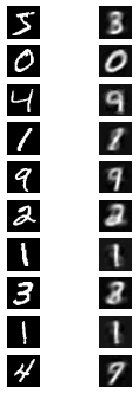

In [9]:
# ORIGINAL vs RECONSTRUCTED
n = 10
fig = plt.figure(figsize=(3, 7))
for i in range(n):
    before = x_train[i].reshape(28, 28)
    after = predictions[i].reshape(28, 28)
    ax = fig.add_subplot(n, 2, (i * 2) + 1)
    ax.imshow(before, cmap='gray')
    ax.axis('off')
    ax = fig.add_subplot(n, 2, (i * 2) + 2)
    ax.imshow(after, cmap='gray')
    ax.axis('off')

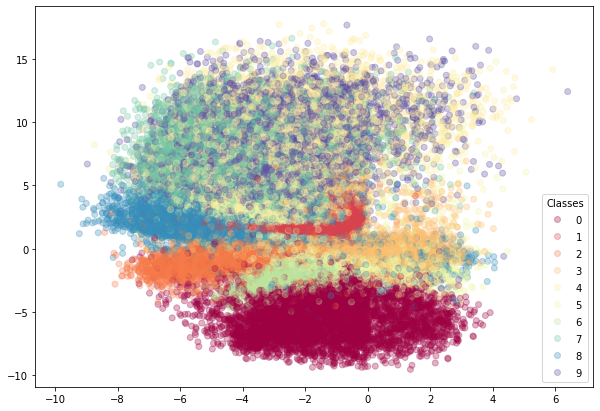

In [10]:
# LATENT SPACE
dim_2 = encoder.predict(x_train)
plt.figure(figsize=(10, 7))
scatter = plt.scatter(*dim_2.T, c=y_train, alpha=0.3, cmap='Spectral')
elements = scatter.legend_elements()
plt.legend(*elements, title='Classes');

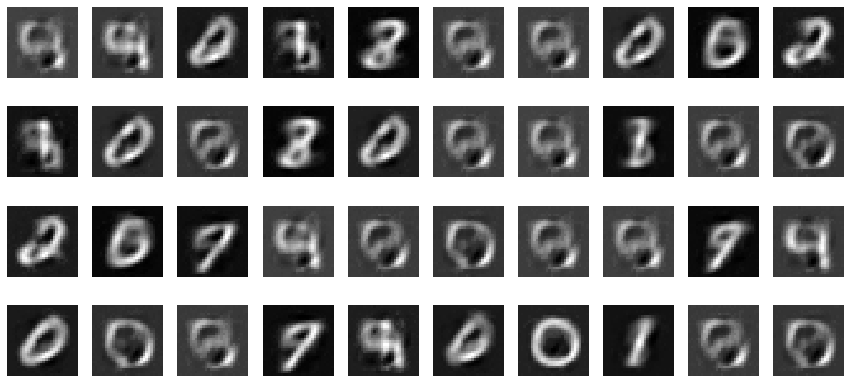

In [41]:
# GENERATING DIGITS BY SAMPLING FROM THE LATENT SPACE
fig = plt.figure(figsize=(15, 7))
for i in range(40):
    x, y = np.random.uniform(-10, 15, 2) # see graph above for potential values
    ax = fig.add_subplot(4, 10, i + 1)
    ax.imshow(decoder.predict([[x, y]]).reshape(28, 28), cmap='gray')
    ax.axis('off')